# Plot of the simulation execution time on the A30 and A40 Nvidia Boards

Here we tested the execution time of the whole code for the vollowing cofiguration.

## Data sample

- Data sample : AMS-02_PRL2019
- Ion : He3
- Starting date: 19/05/2011 
- End date : 15/11/2017
- (r, $\theta$, $\phi$) : (1, 0, 0)
- Reference : DOI: https://dx.doi.org/10.1103/PhysRevLett.123.181102

## Computation configuration

Too speed up the simulation and remove all incidental operations of the code, we simulate only one bin of energy:
|Rigidity    |Flux        |ErrInf      |ErrSup     |
|------------|------------|------------|-----------|
|1.25000e+01 |2.44600e-01 |6.35059e-03 |6.35059e-03|


## GPU hardware and capabilities description

### NVIDIA A30
- Compute capability:  8.0
- Clock rate:  1440000
- Total global mem:  25229983744
- Total constant Mem:  65536
- Max mem pitch:  2147483647
- Texture Alignment:  512
- Multiprocessor count:  56
- Shared mem per mp:  49152
- Registers per mp:  65536
- Threads in warp:  32
- Warps per Multiprocessor:  64
- Threads per Multiprocessor:  2048
- Thread Blocks per Multiprocessor:  32
- Max threads per block:  1024

### NVIDIA A40
- Compute capability:  8.6
- Clock rate:  1740000
- Total global mem:  47619112960
- Total constant Mem:  65536
- Max mem pitch:  2147483647
- Texture Alignment:  512
- Multiprocessor count:  84
- Shared mem per mp:  49152
- Registers per mp:  65536
- Threads in warp:  32
- Warps per Multiprocessor:  48
- Threads per Multiprocessor:  1536
- Thread Blocks per Multiprocessor:  16
- Max threads per block:  1024

## Simulation launch configuration

- The number of 5000 particles is rounded to 5632 to fit the warpsize
- The number of warps per block was varied from 2 to 32 for each GPU board (only the avilable values of warps per block are taken into account)
- The number of blocks is computed by rounding the $\frac{Npart}{WpB*WarpSize}$ ratio
- The number of threads per block is computed by rounding the $\frac{Npart}{Nblocks}$ ratio

### Execution example
propagation Kernel
- Max Number of Warp in a Block   : 2
- Number of blocks                : 88 
- Number of threadsPerBlock       : 64 

Histogram Kernel
- Number of Warp in a Block       : 1024 
- Number of blocks                : 6 
- Number of threadsPerBlock       : 939 

Energy: 7.45 GeV 
- EMin = 7.454 Emax = 9.814 
- N Output binning: 33 
- Time to back-propagate particles:
    - Init              :  0.06 ms 
    - propagation phase :  3911.77 ms 
    - Find Max          :  0.33 ms 
    - Binning           :  0.15 ms 
- Time to Set Memory:  12.0 ms 
- Time to create Rnd:  12.1 ms (delta = 0.1)
- Time to execute   :  3924.4 ms (delta = 3912.4)

## Plot of the execution time in function of the warps per block

### Load data

In [6]:
import numpy as np
import copy
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pandas as pd
import seaborn as sn
import os

exe_times_dict = {
      "name": "",          # Code and GPU used
      "version": "",
      "isotope_id": np.array([]),
      "time": np.array([]) # seconds
}

local_dir = "/home/nfsdisk/DevGC/NewArchitecture/Cosmica_speed_test"

code_dir_list = ["Cosmica_V1-speedtest", "Cosmica_V2-speedtest", "Cosmica_V3-speedtest", "Cosmica_V5-speedtest"]
                # "HelMod_V0-speedtest", "Cosmica_V1-speedtest", "Cosmica_V2-speedtest", "Cosmica_V3-speedtest", "Cosmica_V5-speedtest"
isotopes_list = ["Beryllium","Beryl7","Beryl10", "Iron","Iro54","Iro55","Iro57","Iro58","Iro60" "Proton","Deuteron"] 

exe_times_dicts = np.array([])

run_rep = 10

for code_dir in code_dir_list:
    try:
        code_version = (code_dir.split("-")[0]).split("_")[1]
        exe_times_file = open(f"{local_dir}/{code_dir}/SimExeTimes_{code_version}.txt")
        lines = exe_times_file.readlines()
        nSim = len(lines)
        local_exe_times_dict = copy.deepcopy(exe_times_dict)

        code_name = code_dir.split("-")[0]

        local_exe_times_dict["name"] = (code_dir.split("-")[0]).split("_")[0]
        local_exe_times_dict["version"] = code_version
        exe_times_file.close()

        for sim_id in range(nSim):
            line = lines[sim_id]
            exe_time = line.split()[-2]
            isotope = (line.split()[3]).split("_")[3]
            if exe_time != "X":
                local_exe_times_dict["time"] = np.append(local_exe_times_dict["time"], round(float(exe_time)/1000, 4))
                local_exe_times_dict["isotope_id"] = np.append(local_exe_times_dict["isotope_id"], isotopes_list.index(isotope))

        exe_times_dicts = np.append(exe_times_dicts, local_exe_times_dict)

    except FileNotFoundError:
                    print(f"ERROR: SimExeTimes_{code_version}.txt not found\n")
print(exe_times_dicts)

ValueError: 'Proton' is not in list

### Execution time comparison plot

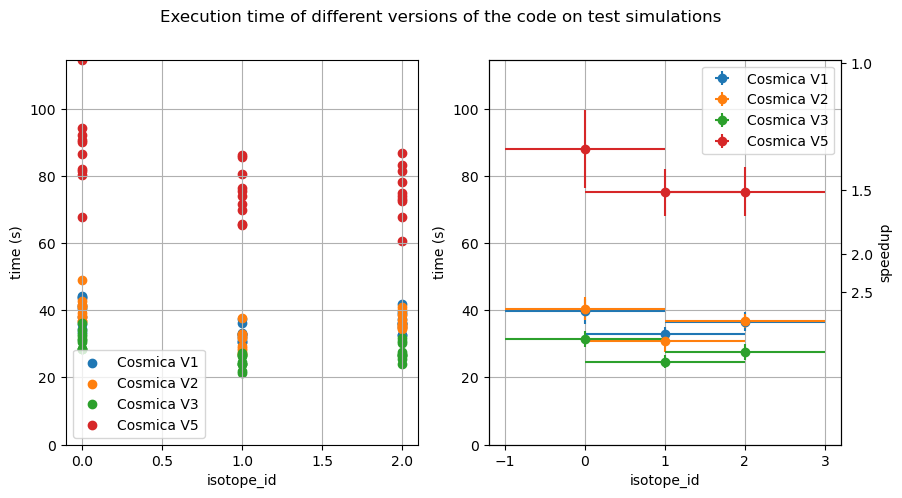

In [2]:
# Fit the two data sample with possible functions
def func1(x, a, b, c):
    return a*(x-c)+b

def func2(x, a, b, c):
    return a*(x-c)**2 +b

fit_func_list = [{"name": "linear", "func": func1, "params": ["a", "b", "c"]}]
                 #{"name": "quadratic", "func": func2, "params": ["a", "b", "c"]}]


popts = np.empty((len(isotopes_list), len(fit_func_list)))
pcovs = np.empty((len(isotopes_list), len(fit_func_list)))

i = 0

fig1, ax1 = plt.subplots(1,2, figsize=(10, 5))

for version_id in range(len(exe_times_dicts)):

    # Scattering plots
    ax1[0].scatter(exe_times_dicts[version_id]["isotope_id"], exe_times_dicts[version_id]["time"], label=exe_times_dicts[version_id]["name"]+" "+exe_times_dicts[version_id]["version"], marker="o")

    '''# Fitting functions
    for fit_func_id in range(len(fit_func_list)):
        function = fit_func_list[fit_func_id]
        popt, pcov = curve_fit(function["func"], exe_times_dicts[version_id]["isotope_id"], exe_times_dicts[version_id]["time"])
        # popts[version_id][fit_func_id] = {"params": popt}
        # pcovs[version_id][fit_func_id] = {"params": pcov}
        fit_name = function["name"]
        GPU_name = exe_times_dicts[version_id]["name"]
        ax1[0].plot(exe_times_dicts[version_id]["isotope_id"], function["func"](exe_times_dicts[version_id]["isotope_id"], *popt), '--', label=f'{fit_name} fit {GPU_name}')
        print(f"Best fitting parameters for {fit_name} function on {GPU_name} board:")
        for par_id in range(len(function["params"])):
            locsal_params = function["params"]
            print(f"{locsal_params[par_id]}={popt[par_id]:.2f}")'''

    # Everage + error bars plots
    exe_mean = np.average(exe_times_dicts[version_id]["isotope_id"].reshape(-1, run_rep), axis=1)
    exe_errors = exe_mean[1] - exe_mean[0]
    exe_time_mean = np.average(exe_times_dicts[version_id]["time"].reshape(-1, run_rep), axis=1)
    exe_time_errors = np.std(exe_times_dicts[version_id]["time"].reshape(-1, run_rep), axis=1)
    ax1[1].errorbar(exe_mean, exe_time_mean, yerr=exe_time_errors, xerr=exe_errors, label=exe_times_dicts[version_id]["name"]+" "+exe_times_dicts[version_id]["version"], fmt='o')
    
    for fit_func_id in range(len(fit_func_list)):
        function = fit_func_list[fit_func_id]
        popt, pcov = curve_fit(function["func"], exe_times_dicts[version_id]["isotope_id"], exe_times_dicts[version_id]["time"])
        # popts[version_id][fit_func_id] = {"params": popt}
        # pcovs[version_id][fit_func_id] = {"params": pcov}
        fit_name = function["name"]
        GPU_name = exe_times_dicts[version_id]["name"]
        '''ax1[1].plot(exe_times_dicts[version_id]["isotope_id"], function["func"](exe_times_dicts[version_id]["isotope_id"], *popt), '--', label=f'{fit_name} fit {GPU_name}')
        print(f"Best fitting parameters for {fit_name} function on {GPU_name} board:")
        for par_id in range(len(function["params"])):
            locsal_params = function["params"]
            print(f"{locsal_params[par_id]}={popt[par_id]:.2f}")'''

    min = np.inf
    max = 0

    max_ = np.max(exe_times_dicts[version_id]["time"])
    if max_>max:
        max = max_
    min_ = np.min(exe_times_dicts[version_id]["time"])
    if min_<min:
        min = min_
    max_speedup = max/min

# Show of the plot and set of its box
fig1.suptitle("Execution time of different versions of the code on test simulations")
ax1[0].set_xlabel("isotope_id")
ax1[0].set_ylabel("time (s)")
ax1[0].set_ylim(0, max+0.1)
ax1[0].legend()
ax1[0].grid()
ax1[1].set_xlabel("isotope_id")
ax1[1].set_ylabel("time (s)")
ax1[1].set_ylim(0, max+0.1)
ax1[1].legend()
ax1[1].grid()
ax2 = ax1[1].twinx()
tot_time = np.sort(np.append(exe_times_dicts[0]["time"], exe_times_dicts[1]["time"]))
speedup_scale = np.round(max/tot_time, 2)
f = lambda a: 1/(a+1e-8)
g = lambda b: 1/(b+1e-8)
plt.yscale("function", functions=(f, g))
ax2_values = np.arange(1, max_speedup+1, 0.5)
ax2.set_yticks(ax2_values)
ax2.set_ylim(max/(max+1), 1/1e-8)
# ax2.invert_yaxis()
ax2.set_ylabel("speedup")
save_name = exe_times_dicts[version_id]["name"].split("_")[0]
fig1.savefig(f"{local_dir}/test_plots/SimExeTimes_compare_{save_name}.pdf")
fig1.savefig(f"{local_dir}/test_plots/SimExeTimes_compare_{save_name}.jpg")
fig1.show()

Best fitting parameters for linear function on Cosmica board:
a=-1.53
b=51.67
c=-8.92
Best fitting parameters for linear function on Cosmica board:
a=-1.84
b=45.09
c=-3.94
Best fitting parameters for linear function on Cosmica board:
a=-1.91
b=52.01
c=-11.61
Best fitting parameters for linear function on Cosmica board:
a=-6.35
b=189.82
c=-16.38


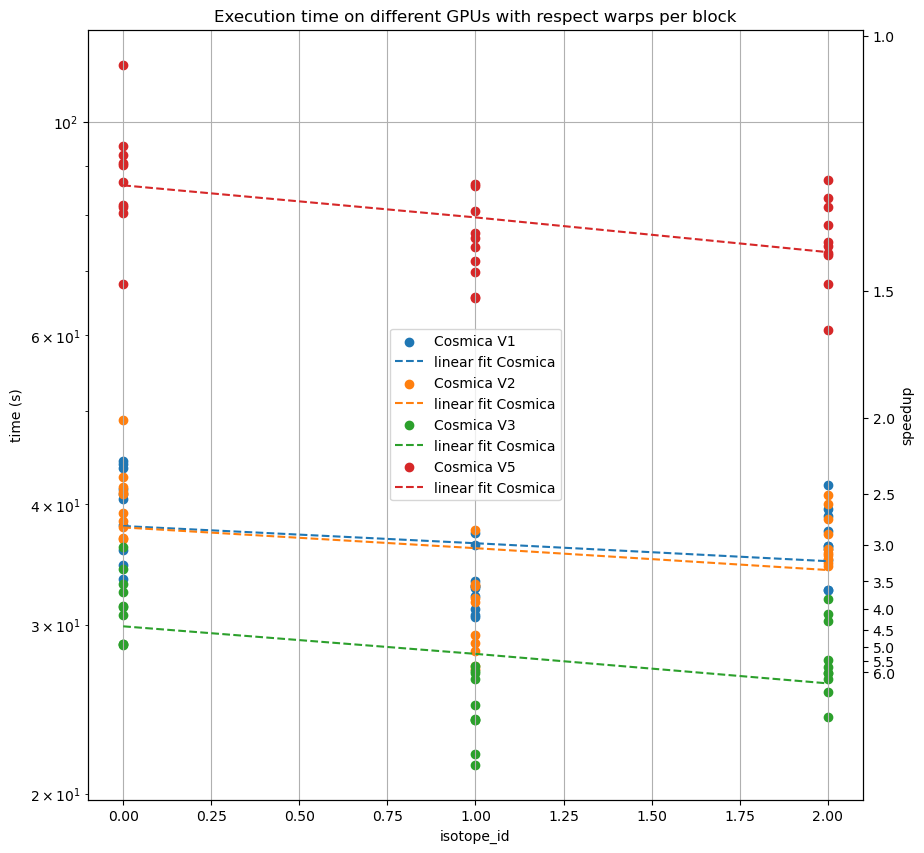

In [3]:
fig2, ax3 = plt.subplots(figsize=(10, 10))

fit_func_list = [{"name": "linear", "func": func1, "params": ["a", "b", "c"]}]
                 #{"name": "quadratic", "func": func2, "params": ["a", "b", "c"]}]

# Compare between Cosmica versions and HelMod for test elements
for version_id in range(len(exe_times_dicts)):
    ax3.scatter(exe_times_dicts[version_id]["isotope_id"], exe_times_dicts[version_id]["time"], label=exe_times_dicts[version_id]["name"]+" "+exe_times_dicts[version_id]["version"], marker="o")
    
    for fit_func_id in range(len(fit_func_list)):
        function = fit_func_list[fit_func_id]
        popt, pcov = curve_fit(function["func"], exe_times_dicts[version_id]["isotope_id"], exe_times_dicts[version_id]["time"])
        # popts[version_id][fit_func_id] = {"params": popt}
        # pcovs[version_id][fit_func_id] = {"params": pcov}
        fit_name = function["name"]
        GPU_name = exe_times_dicts[version_id]["name"]
        ax3.plot(exe_times_dicts[version_id]["isotope_id"], function["func"](exe_times_dicts[version_id]["isotope_id"], *popt), '--', label=f'{fit_name} fit {GPU_name}')
        print(f"Best fitting parameters for {fit_name} function on {GPU_name} board:")
        for par_id in range(len(function["params"])):
            locsal_params = function["params"]
            print(f"{locsal_params[par_id]}={popt[par_id]:.2f}")

    max_ = np.max(exe_times_dicts[version_id]["time"])
    if max_>max:
        max = max_
    min_ = np.min(exe_times_dicts[version_id]["time"])
    if min_<min:
        min = min_
max_speedup = max/min

# Show of the plot and set of its box
ax3.set_title("Execution time on different GPUs with respect warps per block")
ax3.set_xlabel("isotope_id")
ax3.set_ylabel("time (s)")
#ax3.set_ylim(0, max+1)
plt.yscale('log')
ax4 = ax3.twinx()
tot_time = np.sort(np.append(exe_times_dicts[0]["time"], exe_times_dicts[1]["time"]))
speedup_scale = np.round(max/tot_time, 2)
f = lambda a: 1/(a+1e-8)
g = lambda b: 1/(b+1e-8)
plt.yscale("function", functions=(f, g))
ax4_values = np.arange(1, max_speedup+1, 0.5)
ax4.set_yticks(ax4_values)
ax4.set_ylim(max/(max+1), 1/1e-8)
# ax2.invert_yaxis()
ax4.set_ylabel("speedup")
ax3.legend()
ax3.grid()
fig2.savefig(f"{local_dir}/test_plots/SimExeTimes_compare_2codes_scatter.pdf")
fig2.savefig(f"{local_dir}/test_plots/SimExeTimes_compare_2codes_scatter.jpg")
fig2.show()

Best fitting parameters for linear function on Cosmica board:
a=-1.53
b=51.67
c=-8.92
Best fitting parameters for linear function on Cosmica board:
a=-1.84
b=45.09
c=-3.94
Best fitting parameters for linear function on Cosmica board:
a=-1.91
b=52.01
c=-11.61
Best fitting parameters for linear function on Cosmica board:
a=-6.35
b=189.82
c=-16.38


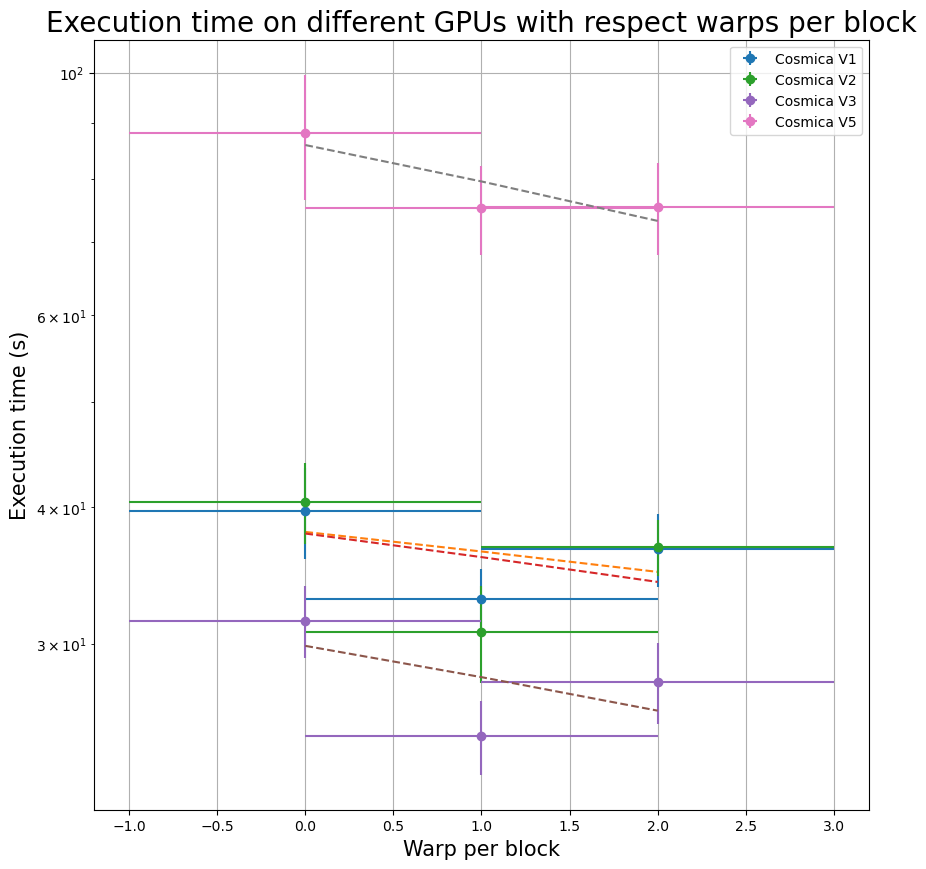

In [4]:
fig2, ax3 = plt.subplots(figsize=(10, 10))

fit_func_list = [{"name": "linear", "func": func1, "params": ["a", "b", "c"]}]
                 #{"name": "quadratic", "func": func2, "params": ["a", "b", "c"]}]
# code_labels = ["Preliminary code V0 A30", "Preliminary code V0 A40", "Cosmica V1 A30", "Cosmica V1 A40"]

# Compare between Cosmica versions and HelMod for test elements
for version_id in range(len(exe_times_dicts)):
    # Everage + error bars plots
    exe_mean = np.average(exe_times_dicts[version_id]["isotope_id"].reshape(-1, run_rep), axis=1)
    exe_errors = exe_mean[1] - exe_mean[0]
    exe_time_mean = np.average(exe_times_dicts[version_id]["time"].reshape(-1, run_rep), axis=1)
    exe_time_errors = np.std(exe_times_dicts[version_id]["time"].reshape(-1, run_rep), axis=1)
    ax3.errorbar(exe_mean, exe_time_mean, yerr=exe_time_errors, xerr=exe_errors, label=exe_times_dicts[version_id]["name"]+" "+exe_times_dicts[version_id]["version"], fmt='o') # label=exe_times_dicts[version_id]["name"])
    
    for fit_func_id in range(len(fit_func_list)):
        function = fit_func_list[fit_func_id]
        popt, pcov = curve_fit(function["func"], exe_times_dicts[version_id]["isotope_id"], exe_times_dicts[version_id]["time"])
        # popts[version_id][fit_func_id] = {"params": popt}
        # pcovs[version_id][fit_func_id] = {"params": pcov}
        fit_name = function["name"]
        GPU_name = exe_times_dicts[version_id]["name"]
        ax3.plot(exe_times_dicts[version_id]["isotope_id"], function["func"](exe_times_dicts[version_id]["isotope_id"], *popt), '--') #, label=f'{fit_name} fit {GPU_name}')
        print(f"Best fitting parameters for {fit_name} function on {GPU_name} board:")
        for par_id in range(len(function["params"])):
            locsal_params = function["params"]
            print(f"{locsal_params[par_id]}={popt[par_id]:.2f}")

    max_ = np.max(exe_times_dicts[version_id]["time"])
    if max_>max:
        max = max_
    min_ = np.min(exe_times_dicts[version_id]["time"])
    if min_<min:
        min = min_
max_speedup = max/min

# Show of the plot and set of its box
ax3.set_title("Execution time on different GPUs with respect warps per block", fontsize=20)
ax3.set_xlabel("Warp per block", fontsize=15)
ax3.set_ylabel("Execution time (s)", fontsize=15)
#ax3.set_ylim(0, max+1)
plt.yscale('log')
'''ax4 = ax3.twinx()
tot_time = np.sort(np.append(exe_times_dicts[0]["time"], exe_times_dicts[1]["time"]))
speedup_scale = np.round(max/tot_time, 2)
f = lambda a: 1/(a+1e-8)
g = lambda b: 1/(b+1e-8)
plt.yscale("function", functions=(f, g))
ax4_values = np.arange(1, max_speedup+1, 0.5)
ax4.set_yticks(ax4_values)
ax4.set_ylim(max/(max+1), 1/1e-8)
# ax2.invert_yaxis()
ax4.set_ylabel("speedup")'''
ax3.legend()
ax3.grid()
fig2.savefig(f"{local_dir}/test_plots/SimExeTimes_compare_codes.pdf")
fig2.savefig(f"{local_dir}/test_plots/SimExeTimes_compare_codes.jpg")
fig2.show()